**Mounting the drive**

In [ ]:
# Mounting drive
from google.colab import drive
drive.mount("/content/drive")

**Data collection for stock price using tiingo api**
 - Disclaimer: API Hit is limited to 50 hits per day

In [ ]:
import pandas_datareader as pdr

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [ ]:
# Data collected from TIINGO API
key = "Use your key!! am not sharing mine"
df = pdr.get_data_tiingo("AAPL",api_key = key)
df.to_csv("/content/drive/My Drive/stock_price_prediction_project/stocks_price.csv")

**Data Exploration**

In [2]:
import pandas as pd
import numpy as np


In [3]:
stocks = pd.read_csv("/content/drive/My Drive/stock_price_prediction_project/stocks_price.csv")

In [4]:
stocks.head(5)

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2015-09-10 00:00:00+00:00,112.57,113.2825,109.90,110.27,62892831,26.003131,26.167715,25.386374,25.471842,251571324,0.0,1.0
1,AAPL,2015-09-11 00:00:00+00:00,114.21,114.2100,111.76,111.79,49915473,26.381964,26.381964,25.816025,25.822955,199661892,0.0,1.0
2,AAPL,2015-09-14 00:00:00+00:00,115.31,116.8900,114.86,116.58,58363431,26.636058,27.001031,26.532110,26.929422,233453724,0.0,1.0
3,AAPL,2015-09-15 00:00:00+00:00,116.28,116.5300,114.42,115.93,43341155,26.860124,26.917872,26.430473,26.779275,173364620,0.0,1.0
4,AAPL,2015-09-16 00:00:00+00:00,116.41,116.5400,115.44,116.25,37173489,26.890153,26.920182,26.666088,26.853194,148693956,0.0,1.0


In [5]:
stocks.tail(5)

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1252,AAPL,2020-08-31 00:00:00+00:00,129.04,131.00,126.00,127.58,223505733,129.04,131.00,126.00,127.58,223505733,0.0,4.0
1253,AAPL,2020-09-01 00:00:00+00:00,134.18,134.80,130.53,132.76,152470142,134.18,134.80,130.53,132.76,152470142,0.0,1.0
1254,AAPL,2020-09-02 00:00:00+00:00,131.40,137.98,127.00,137.59,200118991,131.40,137.98,127.00,137.59,200118991,0.0,1.0
1255,AAPL,2020-09-03 00:00:00+00:00,120.88,128.84,120.50,126.91,257599640,120.88,128.84,120.50,126.91,257599640,0.0,1.0
1256,AAPL,2020-09-04 00:00:00+00:00,120.96,123.70,110.89,120.07,332607163,120.96,123.70,110.89,120.07,332607163,0.0,1.0


In [6]:
stocks.describe()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
count,1257.000000,1257.000000,1257.000000,1257.000000,1.257000e+03,1257.000000,1257.000000,1257.000000,1257.000000,1.257000e+03,1257.000000,1257.000000
mean,182.380151,184.051040,180.452553,182.152037,3.482725e+07,44.768923,45.188718,44.285033,44.717789,1.365255e+08,0.010724,1.002387
std,75.973541,76.864201,74.762357,75.707010,2.047017e+07,20.129452,20.408682,19.770369,20.095441,6.329827e+07,0.085266,0.084616
min,90.340000,91.670000,89.470000,90.000000,1.136200e+07,21.199475,21.511577,20.995318,21.119690,4.544800e+07,0.000000,1.000000
25%,117.810000,118.600000,116.780000,117.640000,2.349733e+07,27.661299,27.806151,27.464464,27.655358,9.398930e+07,0.000000,1.000000
50%,170.420000,171.870000,169.220000,170.430000,2.986944e+07,41.390941,41.805660,41.039335,41.449006,1.194778e+08,0.000000,1.000000
75%,209.680000,212.050000,207.700000,209.880000,4.044491e+07,51.784866,52.515137,51.396392,51.844278,1.615317e+08,0.000000,1.000000
max,506.090000,515.140000,500.330000,514.790000,3.326072e+08,134.180000,137.980000,130.530000,137.590000,5.334787e+08,0.820000,4.000000


In [7]:
stocks = stocks["close"]

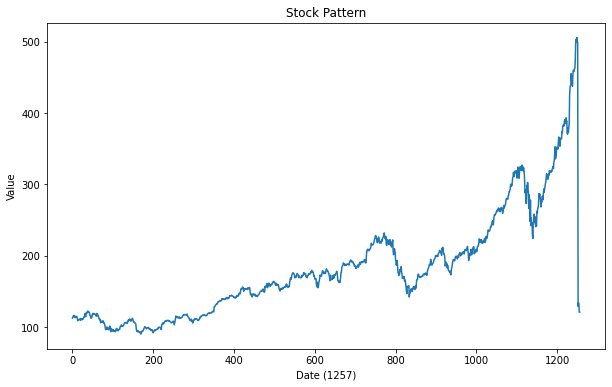

In [8]:
# plot the graph of the price

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
plt.xlabel(f"Date ({stocks.count()})")
plt.ylabel("Value")
plt.title("Stock Pattern")
plt.plot(stocks)
plt.show()

In [9]:
# Scaling of the data
from sklearn.preprocessing import MinMaxScaler
stk = np.array(stocks).reshape(-1,1)

scaler = MinMaxScaler(feature_range=(0,1))
stk = scaler.fit_transform(stk)


In [10]:
stk

array([[0.05346963],
       [0.05741431],
       [0.06006013],
       ...,
       [0.09876127],
       [0.07345761],
       [0.07365003]])

In [11]:
# splitting of data for train and test in ratio 60:40
train_size = int(0.6 * len(stk))
test_size = len(stk) - train_size

train_data = stk[0:train_size,:]
test_data = stk[train_size:len(stk),:1]

In [12]:
train_data.shape,test_data.shape

((754, 1), (503, 1))

In [13]:
# Creating dataset from the above scaled values

def create_dataset(dataset,timestep = 1):
  Xside,Yside = [],[]
  for i in range(len(dataset) - timestep - 1):
    x = dataset[i : i + timestep, 0]
    y = dataset[i + timestep, 0]
    Xside.append(x)
    Yside.append(y)
  return np.array(Xside),np.array(Yside)

In [14]:
# creating training and test data
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [15]:
X_train.shape, y_train.shape

((653, 100), (653,))

In [16]:
X_test.shape, y_test.shape

((402, 100), (402,))

In [17]:
# reshaping for input in LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((653, 100, 1), (402, 100, 1), (653,), (402,))

**Defining the LSTM model**

In [18]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(loss='mean_squared_error',optimizer='adam')

**training and validating the model with the data recorded**

In [20]:
model.fit(X_train,y_train, validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 [==============================] - 1s 103ms/step - loss: 0.0079 - val_loss: 0.0456
Epoch 2/100
11/11 [==============================] - 0s 22ms/step - loss: 0.0021 - val_loss: 0.0083
Epoch 3/100
11/11 [==============================] - 0s 18ms/step - loss: 5.0409e-04 - val_loss: 0.0104
Epoch 4/100
11/11 [==============================] - 0s 19ms/step - loss: 2.9169e-04 - val_loss: 0.0083
Epoch 5/100
11/11 [==============================] - 0s 18ms/step - loss: 2.3925e-04 - val_loss: 0.0082
Epoch 6/100
11/11 [==============================] - 0s 18ms/step - loss: 2.1615e-04 - val_loss: 0.0082
Epoch 7/100
11/11 [==============================] - 0s 18ms/step - loss: 2.0374e-04 - val_loss: 0.0081
Epoch 8/100
11/11 [==============================] - 0s 18ms/step - loss: 2.0229e-04 - val_loss: 0.0085
Epoch 9/100
11/11 [==============================] - 0s 18ms/step - loss: 1.9789e-04 - val_loss: 0.0082
Epoch 10/100
11/11 [==============================] - 0s 18ms/step - lo

**Checking the RSME value for the model**

In [21]:
XtrainPredicted = scaler.inverse_transform(model.predict(X_train))
XtestPredicted = scaler.inverse_transform(model.predict(X_test))

In [22]:
XtrainPredicted.shape, XtestPredicted.shape

((653, 1), (402, 1))

In [23]:
import math
from sklearn.metrics import mean_squared_error
trainrsme =  math.sqrt(mean_squared_error(XtrainPredicted,scaler.inverse_transform(y_train.reshape(-1, 1))))
testrsme = math.sqrt(mean_squared_error(XtestPredicted,scaler.inverse_transform(y_test.reshape(-1, 1))))
print(f"RSME for Train value is {trainrsme}")
print(f"RSME for Test value is {testrsme}")

RSME for Train value is 3.6882275137309395
RSME for Test value is 30.684848571612587


**plotting the predicted values**

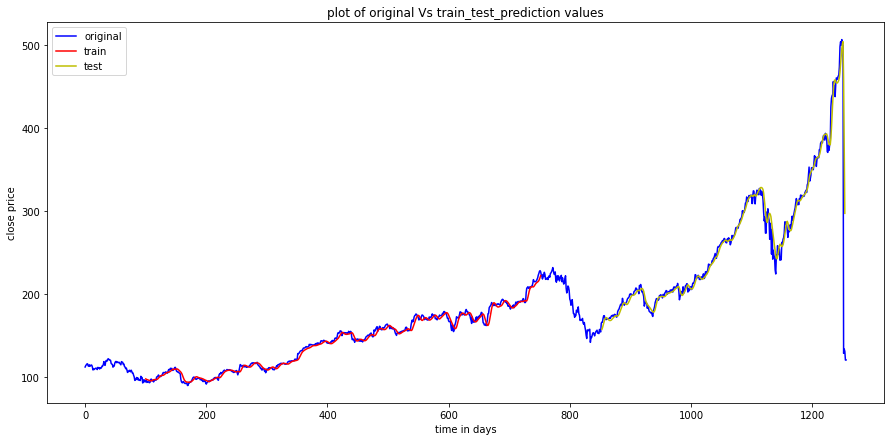

In [55]:
# ploting original stocks
fig = plt.figure(figsize=(15,7))
plt.plot(stocks,"b")

# ploting the training predictions
traindf = np.empty_like(stk)
traindf[:,:] = np.nan
traindf[time_step : time_step + len(XtrainPredicted)] = XtrainPredicted
plt.plot(traindf, "r")

# ploting hte test predictions
testdf = np.empty_like(stk)
testdf[:,:] = np.nan
testdf[2*time_step + len(XtrainPredicted) : 2*time_step + len(XtrainPredicted) + len(XtestPredicted) ] = XtestPredicted
plt.plot(testdf,"y")

plt.xlabel("time in days")
plt.ylabel("close price")
plt.title("plot of original Vs train_test_prediction values")
plt.legend(["original","train","test"])
plt.show()

fig.savefig("/content/drive/My Drive/stock_price_prediction_project/stock_predictions.jpg",dpi = 300)

**Prediction of next 20 days stock values**

In [275]:
# getting last 100 values from scaled stock close prices
last_100_prices = stk[-100:]
last_100_prices.shape

(100, 1)

In [276]:
next_10_days = []

while len(next_10_days) < 10: 
  # updating the shape for model input compatibility
  last_100_prices = np.expand_dims(last_100_prices,axis = 0)

  # Prediction of next day closing value
  next_day = model.predict(last_100_prices)
  next_10_days.append(next_day[0])

  # Updation of the last 100 closing values feature array
  templist = last_100_prices.tolist()[0]
  templist.append(next_day[0])
  templist = templist[1:]
  templist = np.array(templist)
  last_100_prices = templist

In [281]:
next_10_days = np.array(next_10_days)
next_10_days = scaler.inverse_transform(next_10_days)

**Plotting the next 10 days predictions along with training data**

In [288]:
len(next_10_days)

10

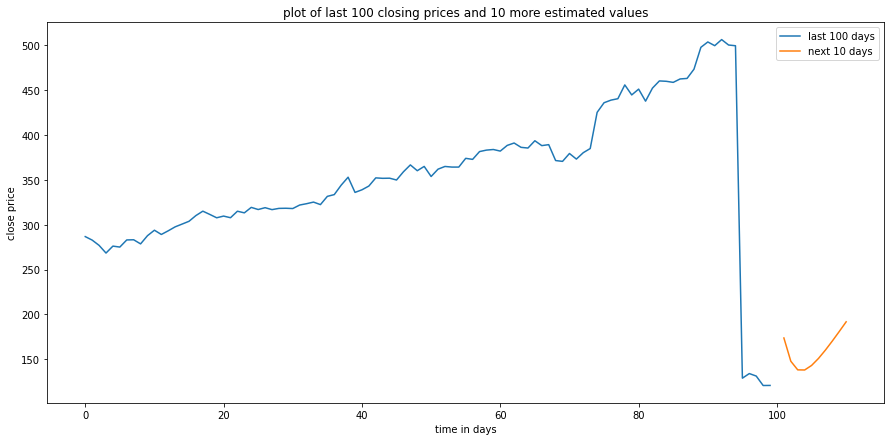

In [292]:

fig = plt.figure(figsize=(15,7))

last_days = np.arange(0,111)

# plotting of last 100 days of actual closing prices
plt.plot(last_days[0:100],scaler.inverse_transform(stk[-100:]))

# ploting of next 10 days estimates
plt.plot(last_days[101:],next_10_days.reshape(next_10_days.shape[0],1))

plt.xlabel("time in days")
plt.ylabel("close price")
plt.title("plot of last 100 closing prices and 10 more estimated values")
plt.legend(["last 100 days","next 10 days"])
plt.show()

fig.savefig("/content/drive/My Drive/stock_price_prediction_project/stock_predictions_next_10_days.jpg",dpi = 300)